In [1]:
import numpy as np
from matplotlib import pyplot as plt

from os import listdir
from os.path import join
from scipy.io import wavfile

import sys
import math

import librosa
import librosa.display
from librosa.effects import trim

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools  

import IPython.display as ipd
from IPython.core.display import display


In [2]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    # Trim the beginning and ending silence
    yt, _ = trim(sample, top_db= top_db)
    return yt

In [3]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [4]:
def stft_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [5]:
def mel_spectrogram(waveform):
    spec = librosa.feature.melspectrogram(y=waveform, sr=8000)
    return librosa.power_to_db(spec, ref=np.max)

In [6]:
def mfcc_spectrogram(waveform):
    spec = librosa.feature.mfcc(y=waveform, sr=8000)
    return spec
    #return sklearn.preprocessing.scale(spec, axis=1)

In [7]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [8]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [9]:
def get_white_noise(signal,SNR) :
    RMS_s=math.sqrt(np.mean(signal.astype(np.int32)**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [10]:
def add_noise(data):  
    newdata = []
    for audio in data:
        noise = get_white_noise(audio, 3)
        newdata.append(audio + noise)
    
    return newdata

In [11]:
def change_pitch(data): 
    newdata = []
    for audio in data:
        newdata.append(librosa.effects.pitch_shift(audio.astype(np.float64), 8000, 3))
    
    return newdata

In [12]:
def stretch(data): 
    newdata = []
    for audio in data:
        newdata.append( librosa.effects.time_stretch(audio.astype(np.float64), 0.8) ) 
    for audio in data:
        newdata.append( librosa.effects.time_stretch(audio.astype(np.float64), 1.4) )
    
    return newdata

In [13]:
def data_augmentation(X, y, *, noise=False, pitch=False, time_stretch=False):
    X2 = [*X]
    y2 = [*y]
    display(ipd.Audio(X2[-1], rate=8000))
    
    if pitch:
        print('Pitch')
        X2 += change_pitch(X)
        y2 += y
        display(ipd.Audio(X2[-1], rate=8000))
      
    if time_stretch:
        print('Time Stretch')
        X2 += stretch(X)
        y2 += 2*y
        display(ipd.Audio(X2[-len(X) - 1], rate=8000))
        display(ipd.Audio(X2[-1], rate=8000))
        
    if noise:
        print('Noise')
        X2 += add_noise(X) 
        y2 += y
        display(ipd.Audio(X2[-1], rate=8000))
        
    return X2, y2

In [14]:
def freq_mask(spec):
    return tfio.audio.freq_mask(spec, param=2).numpy()

In [15]:
def time_mask(spec):
    return tfio.audio.time_mask(spec, param=2).numpy()

### Read Data

In [16]:
files = 'recordings/'
ds_files = listdir(files)

labels = [str(i) for i in range(10)]
rate = 8000

X = []
y = []

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    
    #trimmed_data = trim_silence(data.astype(np.float16))
    #if trimmed_data.shape[0] == 1:
    #    print(file)
    #    display(ipd.Audio( data , rate=8000 ))
    X.append(data.astype(np.float))
    y.append(label)
    

min_size = 100000
for x in X:
    min_size = min(min_size, x.shape[0])
print(min_size)

1148


In [17]:
%%capture --no-stdout --no-display

#X, y = data_augmentation(X, y, noise=True, pitch=True, time_stretch=True)

print(len(X), len(y))

3000 3000


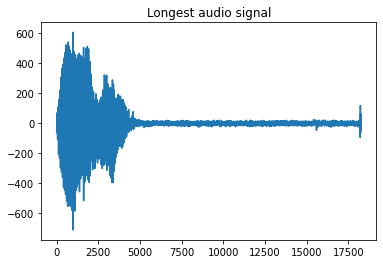

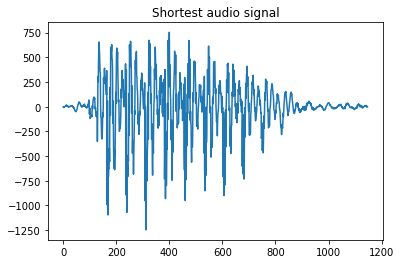

Max sizing before: 18262
Max sizing after: 6457


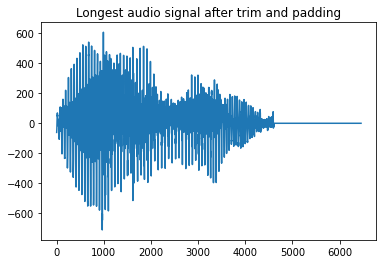

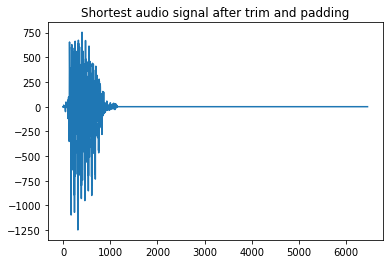

In [18]:
longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[longest_audio])
plt.title("Longest audio signal")
plt.show()

display(ipd.Audio(X[longest_audio], rate=rate))

shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[shortest_audio])
plt.title("Shortest audio signal")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=rate))


max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing before:', max_size)

# trim silence
X = [ remove_silence(x) for x in X ]

# add padding to max size
max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing after:', max_size)
    
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ]

plt.plot(X[longest_audio])
plt.title("Longest audio signal after trim and padding")
plt.show()

display(ipd.Audio(X[longest_audio], rate=rate))

plt.plot(X[shortest_audio])
plt.title("Shortest audio signal after trim and padding")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=rate))

In [19]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(x_train), len(x_val), len(x_test))

1800 600 600


(128, 13)
(20, 13)


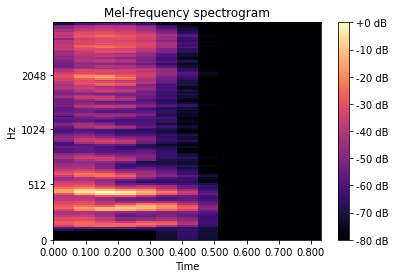

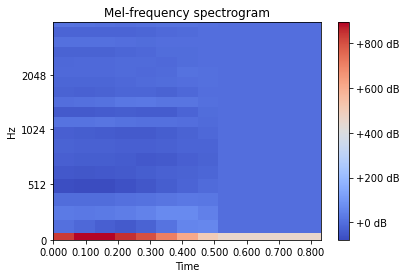

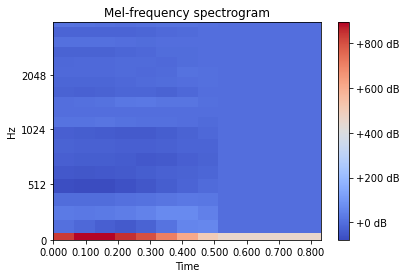

In [20]:
#librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=512,n_mfcc=128)

#spec = librosa.stft(X[1500])

wave = X[2000]

S = mel_spectrogram(wave)


fig, ax = plt.subplots()

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

print(S.shape)

S = mfcc_spectrogram(wave)


fig, ax = plt.subplots()

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')


S2 = freq_mask(time_mask(S))

fig, ax = plt.subplots()

img = librosa.display.specshow(S2, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')


print(S.shape)

(49, 129)


/home/leand/anaconda3/envs/my-conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/leand/anaconda3/envs/my-conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


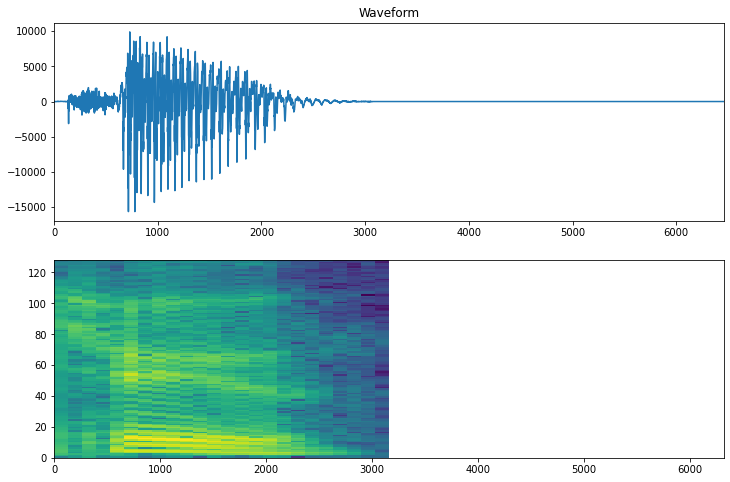

In [21]:
waveform = X[0]

spectrogram = stft_spectrogram(waveform).numpy()
#spectrogram.resize(32, 32)
print(spectrogram.shape)

timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])
plot_spectrogram(spectrogram, axes[1])


### Convert Data to Spectrogram

In [22]:
# try different spec lambdas
spec = lambda X: np.array([mfcc_spectrogram(x) for x in X])


x_train_cur = spec(x_train)
x_val_cur = spec(x_val)
x_test_cur = spec(x_test)

print(x_train_cur.shape)

(1800, 20, 13)


### Model

In [23]:
input_shape = x_train_cur.shape
num_labels = 10

print(input_shape)

#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=(*x_train_cur[0].shape, 1)),
    preprocessing.Resizing(32, 32), 
    #norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

(1800, 20, 13)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 25
history = model.fit(
    x_train_cur, 
    np.array(y_train),
    validation_data=(x_val_cur, np.array(y_val)),  
    epochs=EPOCHS
)

Epoch 1/25
57/57 [==============================] - 3s 35ms/step - loss: 3.6510 - accuracy: 0.4350 - val_loss: 0.4494 - val_accuracy: 0.8517
Epoch 2/25
57/57 [==============================] - 1s 26ms/step - loss: 0.4824 - accuracy: 0.8411 - val_loss: 0.1840 - val_accuracy: 0.9400
Epoch 3/25
57/57 [==============================] - 2s 27ms/step - loss: 0.2826 - accuracy: 0.9033 - val_loss: 0.1751 - val_accuracy: 0.9533
Epoch 4/25
57/57 [==============================] - 2s 30ms/step - loss: 0.1867 - accuracy: 0.9356 - val_loss: 0.1014 - val_accuracy: 0.9717
Epoch 5/25
57/57 [==============================] - 1s 25ms/step - loss: 0.1511 - accuracy: 0.9522 - val_loss: 0.0907 - val_accuracy: 0.9733
Epoch 6/25
57/57 [==============================] - 2s 31ms/step - loss: 0.1245 - accuracy: 0.9589 - val_loss: 0.0972 - val_accuracy: 0.9700
Epoch 7/25
57/57 [==============================] - 1s 25ms/step - loss: 0.1037 - accuracy: 0.9639 - val_loss: 0.1002 - val_accuracy: 0.9717
Epoch 8/25
57

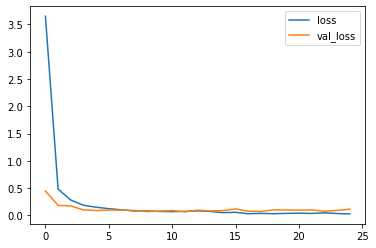

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

### Confusion Matrix

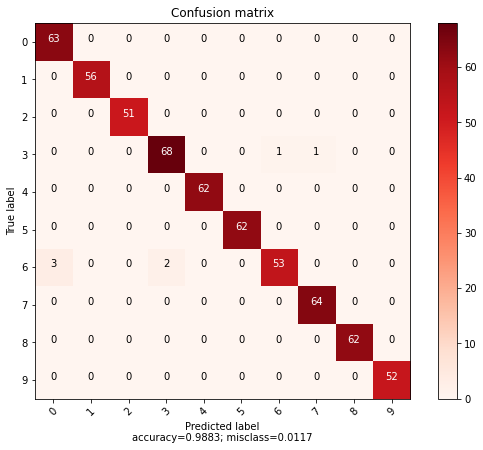

In [27]:
y_pred = model.predict(x_test_cur)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = y_test

cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, labels, normalize=False)

### Results Analysis

In [28]:
def record_audio():
    import pyaudio
    import wave

    chunk = 1024  # Record in chunks of 1024 samples
    sample_format = pyaudio.paInt16  # 16 bits per sample
    channels = 1
    fs = 8000  # Record at 44100 samples per second
    seconds = 2
    filename = "output.wav"

    p = pyaudio.PyAudio()  # Create an interface to PortAudio

    print('Recording')

    stream = p.open(format=sample_format,
                    channels=channels,
                    rate=fs,
                    frames_per_buffer=chunk,
                    input=True)

    frames = []  # Initialize array to store frames

    # Store data in chunks for 3 seconds
    for i in range(0, int(fs / chunk * seconds)):
        data = stream.read(chunk)
        frames.append(data)

    # Stop and close the stream 
    stream.stop_stream()
    stream.close()
    # Terminate the PortAudio interface
    p.terminate()

    print('Finished recording')

    # Save the recorded data as a WAV file
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(sample_format))
    wf.setframerate(fs)
    wf.writeframes(b''.join(frames))
    wf.close()
    
#record_audio()

(15360,)


(3072,)
6457 3072
(20, 13)


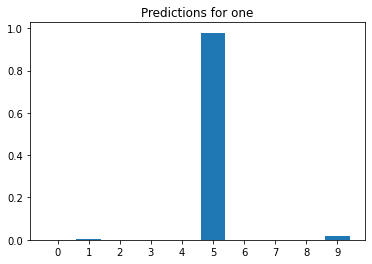

In [29]:
rate, data = wavfile.read("output.wav")
print(data.shape)

trimmed_data = remove_silence(data.astype(np.float))

display(ipd.Audio(trimmed_data, rate=8000))

print(trimmed_data.shape)

print(max_size, trimmed_data.shape[0])

my_X = np.pad(trimmed_data, (0, max_size - trimmed_data.shape[0]))

my_spec = librosa.feature.mfcc(y=my_X, sr=8000)
print(my_spec.shape)

'''
y_pred = model.predict(my_spec.reshape(1, *my_spec.shape, 1))
predicted_categories = tf.argmax(y_pred, axis=1)
print(predicted_categories)
'''

prediction = model(my_spec.reshape(1,*my_spec.shape, 1))
plt.bar(labels, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for one')
plt.show()


[['0_leandro_0.wav', '0_leandro_1.wav'], ['1_leandro_0.wav', '1_leandro_1.wav', '1_random_0.wav', '1_random_1.wav'], ['2_leandro_0.wav', '2_leandro_1.wav', '2_random_0.wav'], ['3_leandro_0.wav', '3_leandro_1.wav', '3_random_0.wav', '3_random_1.wav'], ['4_leandro_0.wav', '4_leandro_1.wav', '4_random_0.wav', '4_random_1.wav'], ['5_leandro_0.wav', '5_leandro_1.wav'], ['6_leandro_0.wav', '6_leandro_1.wav'], ['7_leandro_0.wav', '7_leandro_1.wav'], ['8_leandro_0.wav', '8_leandro_1.wav'], ['9_leandro_0.wav', '9_leandro_1.wav']]


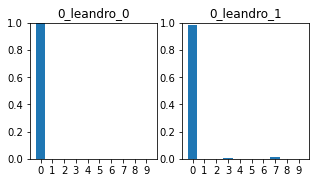

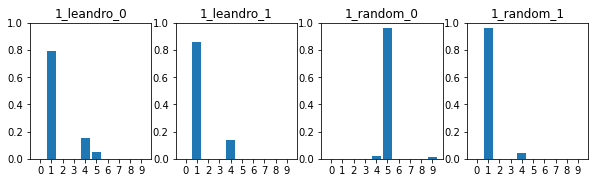

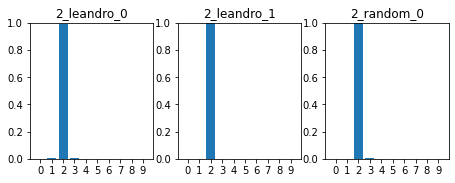

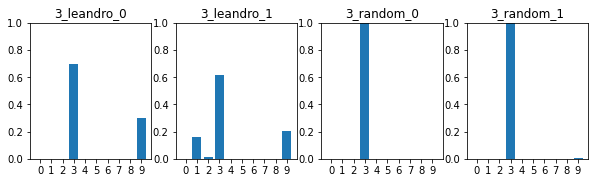

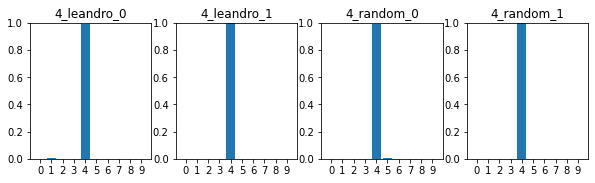

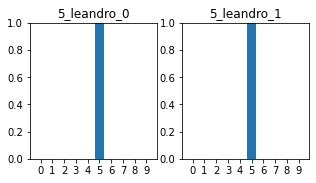

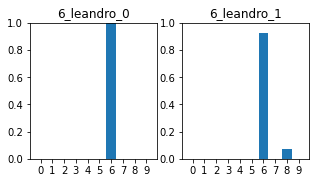

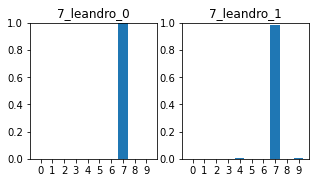

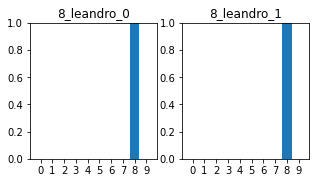

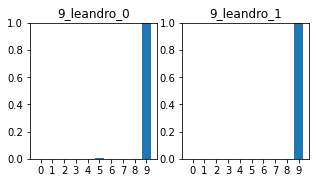

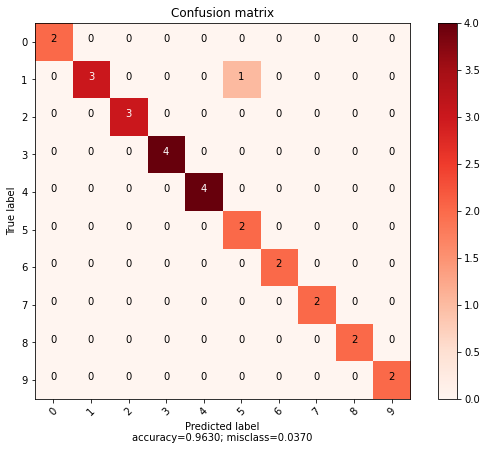

In [34]:
files = 'new_recordings/'
ds_files = listdir(files)
ds_files.sort()

# divide files in labels
ds_chunks = [[file for file in ds_files if file.split("_")[0] == l] for l in labels  ]
    

print(ds_chunks)

predicted_categories = []
true_categories = []

for chunk in ds_chunks:
    
    fig, axes = plt.subplots(nrows=1, ncols=len(chunk), squeeze=False)
    sample = -1
    
    for file in chunk:
        label = int(file.split("_")[0])
        sample += 1
        
        ax = axes[0][sample]
        ax.set_ylim([0,1])

        rate, data = wavfile.read(join(files, file))

        #trimmed_data = trim_silence(data.astype(np.float16))
    
        trimmed_data = remove_silence(data.astype(np.float))

        display(ipd.Audio(trimmed_data, rate=8000))

        x = np.pad(trimmed_data, (0, max(max_size - trimmed_data.shape[0], trimmed_data.shape[0])))

        x_spec = librosa.feature.mfcc(y=x, sr=8000)

        
        (prediction,) = model(x_spec.reshape(1, *x_spec.shape, 1))
        ax.bar(labels, tf.nn.softmax(prediction))
        ax.set_title(f'{file[:-4]}')
        
        predicted_categories.append(tf.argmax(prediction))
        true_categories.append(label)
        
    fig.set_size_inches(2.5*len(chunk), 2.5, forward=True)
    plt.show()

    
cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, labels, normalize=False)